# Pneumonia Prediction Model

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
%matplotlib inline

### Visualization and Exploration

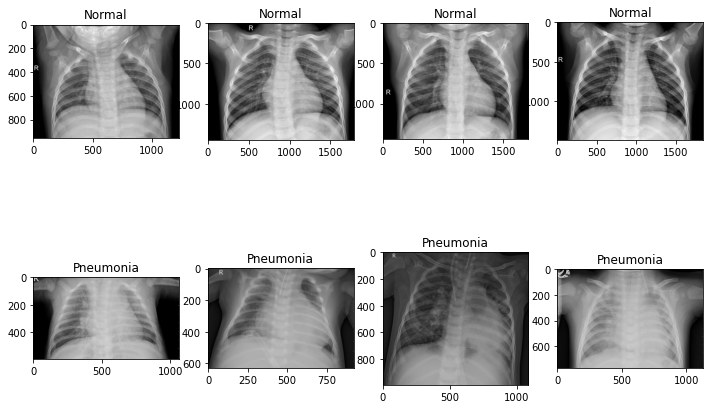

In [2]:
fig = plt.figure(figsize=(12, 8))
for i in range(4):
    image_path = random.choice(os.listdir('chest_xray/train/NORMAL/'))
    image = Image.open(os.path.join('chest_xray/train/NORMAL/', image_path))
    fig.add_subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Normal')
for i in range(4, 8):
    image_path = random.choice(os.listdir('chest_xray/train/PNEUMONIA/'))
    image = Image.open(os.path.join('chest_xray/train/PNEUMONIA/', image_path))
    fig.add_subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia')

*Check the total data entries for each category*

        type  count
0     normal   1341
1  pneumonia   3875


Text(0.5, 1.0, 'Number of Data for each Type')

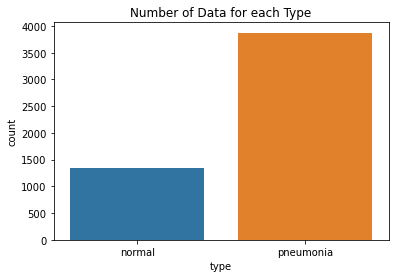

In [3]:
path_norm = 'chest_xray/train/NORMAL/'
path_pneu = 'chest_xray/train/PNEUMONIA/'
len_norm = len(os.listdir(path_norm))
len_pneu = len(os.listdir(path_pneu))

count_df = pd.DataFrame({'type':['normal','pneumonia'], 'count':[len_norm, len_pneu]}, index=range(2))
print(count_df)
sns.barplot(x='type', y='count', data=count_df)
plt.title('Number of Data for each Type')

The data is unbalance, which might be an issue for the predictive model. I would try to resample the train set for Pneumonia to match the count of normal type. Doing so will reduce the size of Pneumonia data, but it is interesting to see how it goes. 

*Resample the train set for pneumonia with the size=1800 files*

In [4]:
try: 
    os.mkdir('chest_xray/new_train')
    
    try:
        os.mkdir('chest_xray/new_train/NORMAL')
        os.mkdir('chest_xray/new_train/PNEUMONIA')

        pneu_files = np.random.choice(os.listdir(path_pneu), size=1800, replace=False)
        for i in pneu_files:
            src_path = path_pneu + i
            dest_path = 'chest_xray/new_train/PNEUMONIA/' + i
            shutil.copy(src_path, dest_path)

        for file in os.listdir(path_norm):
            src_norm = path_norm + file
            dest_norm = 'chest_xray/new_train/NORMAL/' + file
            shutil.copy(src_norm, dest_norm)

    except FileExistsError:
        print('File is already existed!')
        
except FileExistsError:
    print('File is already existed!')

In [5]:
len(os.listdir('chest_xray/new_train/PNEUMONIA'))

1800

### Data Preprocessing

In [6]:
# Generate Image for trainset
train_datagen = ImageDataGenerator(shear_range=0.5, horizontal_flip=True, 
                                zoom_range=0.3, rescale=1./255)
train_set = train_datagen.flow_from_directory('chest_xray/new_train/', 
                                             target_size=(64, 64),
                                             color_mode='grayscale',
                                             class_mode='binary',
                                             batch_size=32)

Found 3141 images belonging to 2 classes.


In [7]:
# Test and validation set
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('chest_xray/test/',
                                           target_size=(64, 64),
                                           color_mode='grayscale',
                                           class_mode='binary',
                                           batch_size=32)

val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_directory('chest_xray/val/',
                                         target_size=(64, 64),
                                         color_mode='grayscale',
                                         class_mode='binary',
                                         batch_size=32)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Building CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Activation, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

*Convolution and Pooling of Image (Convolution 1)*

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Convolution and Pooling of Image (Convolution 2)*

In [10]:
model.add(Conv2D(filters=32, kernel_size=3, input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Convolution and Pooling of Image (Convolution 3)*

In [11]:
model.add(Conv2D(filters=32, kernel_size=3, input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

*Flattening Image*

In [12]:
model.add(Flatten())

*Full Connection Network*

In [13]:
model.add(Dense(128, activation='relu'))
model.add(Dense(68, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
ES = EarlyStopping(monitor='val_loss', patience=8, mode='min')

model.fit(train_set, validation_data=test_set, epochs=100, verbose=1, 
          workers=8, callbacks=[ES])

Epoch 1/100
99/99 [==============================] - 16s 152ms/step - loss: 0.5600 - accuracy: 0.6893 - val_loss: 0.3763 - val_accuracy: 0.8253
Epoch 2/100
99/99 [==============================] - 16s 151ms/step - loss: 0.3599 - accuracy: 0.8408 - val_loss: 0.5436 - val_accuracy: 0.7179
Epoch 3/100
99/99 [==============================] - 15s 149ms/step - loss: 0.2920 - accuracy: 0.8774 - val_loss: 0.3499 - val_accuracy: 0.8397
Epoch 4/100
99/99 [==============================] - 16s 152ms/step - loss: 0.2457 - accuracy: 0.8997 - val_loss: 0.3338 - val_accuracy: 0.8606
Epoch 5/100
99/99 [==============================] - 15s 151ms/step - loss: 0.2300 - accuracy: 0.9118 - val_loss: 0.2612 - val_accuracy: 0.9006
Epoch 6/100
99/99 [==============================] - 16s 151ms/step - loss: 0.2242 - accuracy: 0.9105 - val_loss: 0.2892 - val_accuracy: 0.8798
Epoch 7/100
99/99 [==============================] - 16s 151ms/step - loss: 0.1935 - accuracy: 0.9233 - val_loss: 0.3074 - val_accuracy:

#### Check the model fitting

In [14]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

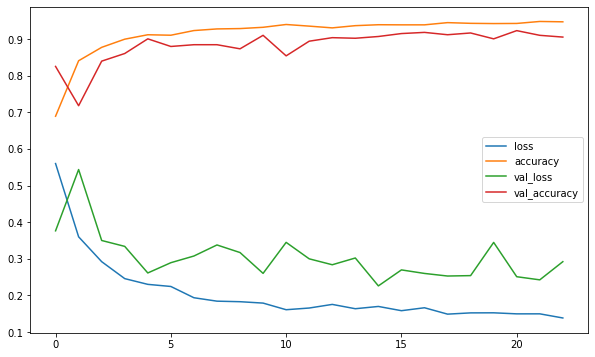

In [15]:
losses.plot(figsize=(10, 6))

##### Mix up and combine the test set for checking the predictive ability of the model 

In [16]:
from keras.preprocessing import image

In [17]:
norm_test_path = 'chest_xray/test/NORMAL/'
pneu_test_path = 'chest_xray/test/PNEUMONIA/'
test_files = list(os.listdir(norm_test_path)) + list(os.listdir(pneu_test_path))

In [18]:
target = list(np.zeros(len(os.listdir(norm_test_path)))) + list(np.ones(len(os.listdir(pneu_test_path))))

In [19]:
image_test_df = pd.DataFrame({'Image': test_files, 'Target': target}, index=range(624))

In [20]:
# Shuffle the test dataframe
image_test_df = image_test_df.sample(frac=1).reset_index(drop=True)
image_test_df

,Image,Target
0,person121_bacteria_580.jpeg,1.0
1,person153_bacteria_726.jpeg,1.0
2,person1616_virus_2802.jpeg,1.0
3,person46_virus_96.jpeg,1.0
4,person36_virus_81.jpeg,1.0
...,...,...
619,NORMAL2-IM-0369-0001.jpeg,0.0
620,person93_bacteria_453.jpeg,1.0
621,IM-0035-0001.jpeg,0.0
622,person25_virus_59.jpeg,1.0


In [21]:
# Transform predictions set into correct format 
def makelist(x):
    pred_list = []
    for i in range(len(x)):
        pred_list.append(int(x[i][0][0]))
    return np.array(pred_list)

In [22]:
# Load test images and convert to array format
image_list = []
for filename in image_test_df['Image']:
    if filename in os.listdir(norm_test_path):
        test_image = image.load_img(norm_test_path + filename,
                                    target_size=(64, 64), color_mode='grayscale')
    else:
        test_image = image.load_img(pneu_test_path + filename, 
                                    target_size=(64, 64), color_mode='grayscale')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    image_list.append(test_image)

In [23]:
# Make predictions for test set
predictions = []
for item in image_list:
    predictions.append(model.predict(item))

### Model Evaluation

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(image_test_df['Target'].values, makelist(predictions)))
print(confusion_matrix(image_test_df['Target'].values, makelist(predictions)))

              precision    recall  f1-score   support

         0.0       0.93      0.74      0.82       234
         1.0       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624

[[174  60]
 [ 14 376]]


In [25]:
# Use validation set to predict the outcome of x-ray images
def val_predict(t):
    pred_val = []
    for file in os.listdir('chest_xray/val/' + t + '/'):
        test_image = image.load_img('chest_xray/val/' + t + '/' + file, 
                                        target_size=(64, 64), color_mode='grayscale')
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis=0)
        pred_val.append(model.predict(test_image))
    return makelist(pred_val)

In [26]:
val_predict('NORMAL')

array([1, 0, 1, 1, 1, 1, 0, 0])

In [27]:
val_predict('PNEUMONIA')

array([1, 1, 1, 1, 1, 1, 1, 1])

**Comment**: The model correctly predict the all the pneumonia cases in the validation set. However, it only predicts 3 out of 8 cases for the normal type. Looking at the confusion matrix, there are 60 false positive cases and 14 false negative cases, which is decent in predicting pneumonia. It is better to have false alarm than completely miss out the patient's condition. 